# AlexNet

Mô hình của AlexNet:
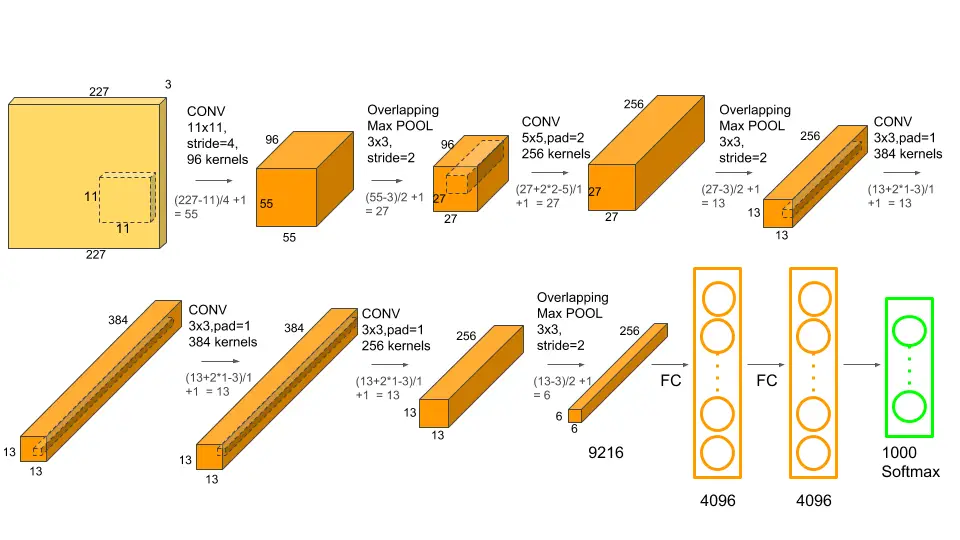


AlexNet bao gồm 5 convolution Layer và 3 Fully connected Layers.

Những convolution layer ( hay còn gọi với tên khác là các filter) rút trích các thông tin hữu ích trong các bức ảnh. Trong một convolution layer bất kỳ thường bao gồm nhiều kernel có cùng kích thước. Ví dụ như convolution layer đầu tiên của AlexNet chứa 96 kernel có kích thước 11x11x3. Thông thường thì width và height của một kernel bằng nhau, và độ sâu (depth) thường bằng số lượng kênh màu.

Convolutional 1 và convolution 2 kết nối với nhau qua một Overlapping Max Pooling ở giữa. Tương tự như vậy giữa convolution 2 và convolution 3. Convolutional 3, convolution 4, convolution 5 kết nối trực tiếp với nhau, không thông qua trung gian. Convolutional 5 kết nối fully connected layter 1 thông qua một Overlapping Max pooling, tiếp theo mà một fully connected layter nữa. Và cuối cùng là một bộ phân lớp softmax với 1000 lớp nhãn (các bạn có thể xem hình kiến trúc mạng AlexNet ở trên để có cái nhìn tổng quát hơn).

ReLU nonlinerity được sử dụng sau tất các các convolution và fully connected layer. Trước đây, ReLU nonlinerity của lớp convolution 1 và 2 thường theo sau bởi một bước chuẩn hoá cục bộ (local normalization) rồi mới thực hiện pooling. Tuy nhiên, các nghiên cứu sau đó nhận thấy rằng việc sử dụng normalization không thật sự hữu ích. Do vậy chúng ta sẽ không đi chi tiết về vấn đề đó.

## Overlapping Max Pooling

Max Pooling layer thường được sử dụng để giảm chiều rộng và chiều dài của một tensor nhưng vẫn giữ nguyên chiều sâu. Overlapping Max Pool layter cũng tương tự như Max Pool layter, ngoại trừ việc là một window của bước này sẽ có một phần chồng lên window của bước tiếp theo. Tác giả sử dụng pooling có kích thước 3x3 và bước nhảy là 2 giữa các pooling. Nghĩa là giữa pooling này và pooling khác sẽ overlapping với nhau 1 pixel. Các thí nghiệm thực tế đã chứng minh rằng việc sử dụng overlapping giữa các pooling giúp giảm độ lỗi top-1 error 0.4% và top-5 error là 0.3% khi so với việc sử dụng pooling có kích thước 2x2 và bước nhảy 2 (vector output của cả hai đều có số chiều bằng nhau).

## ReLu Nonlinearity

Một cải tiến quan trọng khác của AlexNet là việc sử dụng hàm phi tuyến ReLU. Trước đây, các nhóm nghiên cứu khác thường sử dụng hàm kích hoạt là hàm Tanh hoặc hàm Sigmoid để huấn luyên mô hình neural network. AlexNet chỉ ra rằng, khi sử dụng ReLU, mô hình deep CNN sẽ huấn luyện nhanh hơn so với viêc sử dụng tanh hoặc sigmoid.

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler # Using for validation split

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
def get_train_valid_loader(data_dir,
                           batch_size,
                           augment, # whether to augment the data (flip, crop etc.)
                           random_seed,
                           valid_size=0.1,
                           shuffle=True):
    normalize = transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
    )

    # define transforms
    valid_transform = transforms.Compose([
            transforms.Resize((227,227)),
            transforms.ToTensor(),
            normalize,
    ])
    if augment:
        train_transform = transforms.Compose([
            # Randomly crop 32x32 pixel region and zero pad it by 4 pixels on each side holding back the original picture
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(), # Flip horizontally
            transforms.ToTensor(), # Convert to tensor
            normalize,
        ])
    else:
        train_transform = transforms.Compose([
            transforms.Resize((227,227)),
            transforms.ToTensor(),
            normalize,
        ])

    # load the dataset
    train_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=train_transform,
    )

    valid_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=valid_transform,
    )

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle: # shuffle the dataset before splitting into training and validation set
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler)

    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=batch_size, sampler=valid_sampler)

    return (train_loader, valid_loader)


def get_test_loader(data_dir,
                    batch_size,
                    shuffle=True):
    normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    )

    # define transform
    transform = transforms.Compose([
        transforms.Resize((227,227)),
        transforms.ToTensor(),
        normalize,
    ])

    dataset = datasets.CIFAR10(
        root=data_dir, train=False,
        download=True, transform=transform,
    )

    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle
    )

    return data_loader


# CIFAR10 dataset
train_loader, valid_loader = get_train_valid_loader(data_dir = './data',                                      batch_size = 64,
                       augment = False,                             		     random_seed = 1)

test_loader = get_test_loader(data_dir = './data',
                              batch_size = 64)

100%|██████████| 170498071/170498071 [00:03<00:00, 56234777.69it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
def get_train_valid_loader(data_dir,
                           batch_size,
                           augment,
                           random_seed,
                           valid_size=0.1,
                           shuffle=True):
    normalize = transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
    )

    # define transforms
    valid_transform = transforms.Compose([
            transforms.Resize((227,227)),
            transforms.ToTensor(),
            normalize,
    ])
    if augment:
        train_transform = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ])
    else:
        train_transform = transforms.Compose([
            transforms.Resize((227,227)),
            transforms.ToTensor(),
            normalize,
        ])

    # load the dataset
    train_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=train_transform,
    )

    valid_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=valid_transform,
    )

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler)

    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=batch_size, sampler=valid_sampler)

    return (train_loader, valid_loader)

def get_test_loader(data_dir,
                    batch_size,
                    shuffle=True):
    normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    )

    # define transform
    transform = transforms.Compose([
        transforms.Resize((227,227)),
        transforms.ToTensor(),
        normalize,
    ])

    dataset = datasets.CIFAR10(
        root=data_dir, train=False,
        download=True, transform=transform,
    )

    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle
    )

    return data_loader


# CIFAR10 dataset
train_loader, valid_loader = get_train_valid_loader(data_dir = './data',                                      batch_size = 64,
                       augment = False,                             		     random_seed = 1)

test_loader = get_test_loader(data_dir = './data',
                              batch_size = 64)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [ ]:

class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(9216, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [ ]:
num_classes = 10
num_epochs = 20
batch_size = 64
learning_rate = 0.005

model = AlexNet(num_classes).to(device)


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)


# Train the model
total_step = len(train_loader)

In [ ]:

total_step = len(train_loader)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    # Validation
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs

        print('Accuracy of the network on the {} validation images: {} %'.format(5000, 100 * correct / total))

Epoch [1/20], Step [704/704], Loss: 1.0489
Accuracy of the network on the 5000 validation images: 61.98 %
